<a href="https://colab.research.google.com/github/sowad748/Data-Mining-Assignments-/blob/main/Assignment06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python-headless
from google.colab import drive
# 1. Mount drive
drive.mount('/content/drive/')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 27.1 MB/s eta 0:00:00
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 2. Set your dataset path inside Drive
base_path = '/content/drive/MyDrive/FaceRecog'
train_dir = os.path.join(base_path, 'Train')
test_dir = os.path.join(base_path, 'Test')

# 3. Helper to load images and labels
def load_images_from_folder(folder):
    images = []
    labels = []
    label_names = []
    for label_name in sorted(os.listdir(folder)):
        label_path = os.path.join(folder, label_name)
        if os.path.isdir(label_path):
            label_names.append(label_name)
            for file in os.listdir(label_path):
                img_path = os.path.join(label_path, file)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (250, 250))  # Make sure it's 250x250
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                    flat = img.flatten()  # Shape: (187500,)
                    images.append(flat)
                    labels.append(label_name)
    return np.array(images), np.array(labels), label_names

# 4. Load train and test images
X_train, y_train, train_names = load_images_from_folder(train_dir)
X_test, y_test, test_names = load_images_from_folder(test_dir)

print(f"Train images: {X_train.shape}, Labels: {len(y_train)}")
print(f"Test images: {X_test.shape}, Labels: {len(y_test)}")


Train images: (15, 187500), Labels: 15
Test images: (33, 187500), Labels: 33


Simple Face Recognition completed in 32.41 seconds


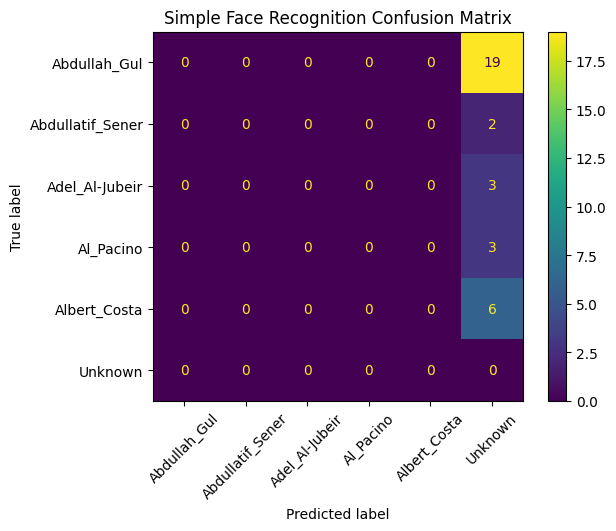

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

def euclidean_distance(x1, x2):
    return np.linalg.norm(x1 - x2)

# Calculate mean of training set to center test images
x_mean = np.mean(X_train, axis=0)

# Recognition threshold (tune if needed)
threshold = 5000  # You may tune this value

y_pred_simple = []
start_time = time.time()

for xtest in X_test:
    # Center the test image if needed (optional step)
    xtest_centered = xtest - x_mean

    # Compute distances to all training images
    distances = [euclidean_distance(xtest_centered, xtrain - x_mean) for xtrain in X_train]

    min_dist = np.min(distances)
    best_match_idx = np.argmin(distances)

    if min_dist < threshold:
        y_pred_simple.append(y_train[best_match_idx])
    else:
        y_pred_simple.append("Unknown")

end_time = time.time()
simple_recog_time = end_time - start_time

# Print results
print(f"Simple Face Recognition completed in {simple_recog_time:.2f} seconds")

# Show confusion matrix (Unknowns will appear as a separate class)
labels_for_cm = np.unique(np.concatenate((y_test, y_pred_simple)))
cm = confusion_matrix(y_test, y_pred_simple, labels=labels_for_cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_for_cm)
disp.plot(xticks_rotation=45)
plt.title("Simple Face Recognition Confusion Matrix")
plt.show()


Using PCA

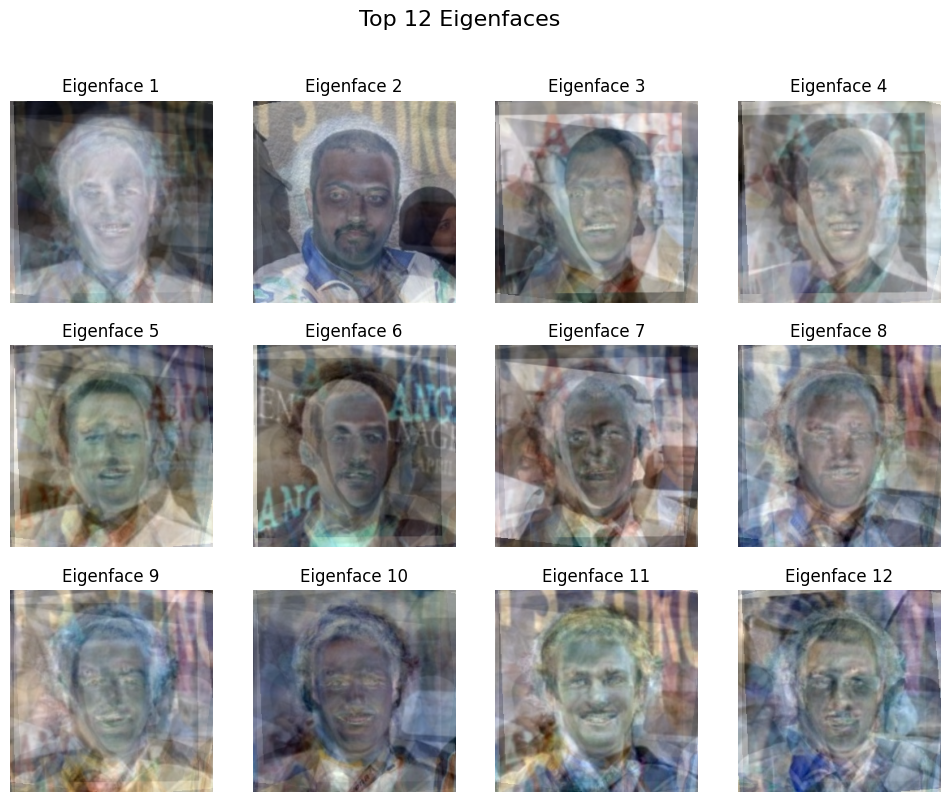

In [ ]:
from numpy.linalg import eigh

# Step 1: Demean the training set
x_mean = np.mean(X_train, axis=0)
X_demeaned = X_train - x_mean

# Step 2: Compute covariance matrix using the transpose trick
# We're solving: u = eigenvectors of (X X^T)
cov_matrix = np.dot(X_demeaned, X_demeaned.T)

# Step 3: Compute top K eigenvectors
K = 12
eigenvalues, eigenvectors = eigh(cov_matrix)

# Get indices of top K largest eigenvalues
top_k_indices = np.argsort(eigenvalues)[::-1][:K]
top_k_eigenvectors = eigenvectors[:, top_k_indices]

# Step 4: Transpose trick to get actual eigenfaces (in original space)
eigenfaces = np.dot(X_demeaned.T, top_k_eigenvectors)  # Shape: (187500, K)

# Normalize eigenfaces
eigenfaces = eigenfaces / np.linalg.norm(eigenfaces, axis=0)

# Step 5: Project training images into eigenface space (get coefficients)
Y_train = np.dot(X_demeaned, eigenfaces)  # Shape: (n_samples, K)

# Visualize top 12 eigenfaces
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
for i, ax in enumerate(axes.flat):
    face = eigenfaces[:, i].reshape(250, 250, 3)
    # Clip and normalize for display
    face = (face - np.min(face)) / (np.max(face) - np.min(face))
    ax.imshow(face)
    ax.set_title(f"Eigenface {i+1}")
    ax.axis('off')
plt.suptitle("Top 12 Eigenfaces", fontsize=16)
plt.show()


Project and Recognition

In [ ]:
# Step 6: Recognize test images using projections
Y_pred_pca = []
start_time_pca = time.time()

for xtest in X_test:
    xtest_demeaned = xtest - x_mean
    y_test_proj = np.dot(xtest_demeaned, eigenfaces)  # Shape: (K,)

    # Compute distance to all projected training samples
    distances = np.linalg.norm(Y_train - y_test_proj, axis=1)

    min_dist = np.min(distances)
    best_idx = np.argmin(distances)

    if min_dist < 3000:  # You can tune this threshold
        Y_pred_pca.append(y_train[best_idx])
    else:
        Y_pred_pca.append("Unknown")

end_time_pca = time.time()
pca_time = end_time_pca - start_time_pca

print(f"PCA + Eigenfaces Recognition completed in {pca_time:.2f} seconds")


PCA + Eigenfaces Recognition completed in 1.29 seconds


Confusion Matrix

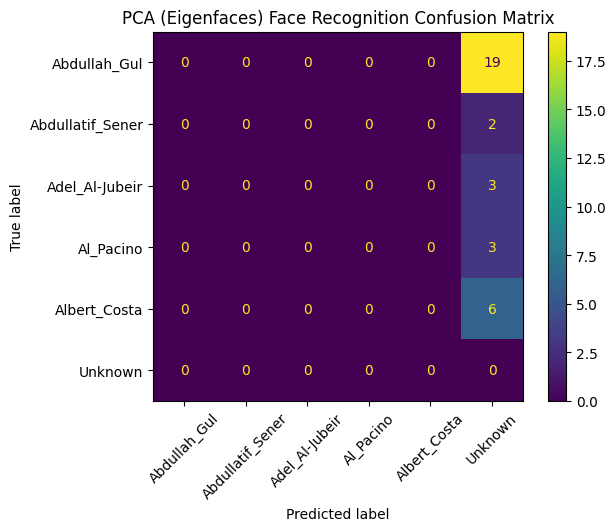

In [ ]:
# Show confusion matrix
labels_for_cm = np.unique(np.concatenate((y_test, Y_pred_pca)))
cm_pca = confusion_matrix(y_test, Y_pred_pca, labels=labels_for_cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_pca, display_labels=labels_for_cm)
disp.plot(xticks_rotation=45)
plt.title("PCA (Eigenfaces) Face Recognition Confusion Matrix")
plt.show()


Summary

In [ ]:
print("=== Method Comparison ===")
print(f"Simple Recognition Time: {simple_recog_time:.2f} seconds")
print(f"PCA Recognition Time: {pca_time:.2f} seconds")
print(f"Total Test Images: {len(y_test)}")
print(f"Correctly Classified (Simple): {np.sum(y_test == y_pred_simple)}")
print(f"Correctly Classified (PCA): {np.sum(y_test == Y_pred_pca)}")


=== Method Comparison ===
Simple Recognition Time: 32.41 seconds
PCA Recognition Time: 1.29 seconds
Total Test Images: 33
Correctly Classified (Simple): 0
Correctly Classified (PCA): 0
